In [ ]:
!pip install pmdarima
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

import pandas_datareader.data as web
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from talib import abstract
import json

     |████████████████████████████████| 1.5MB 19.2MB/s 
     |████████████████████████████████| 2.1MB 50.6MB/s 
     |████████████████████████████████| 9.5MB 31.7MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Selecting previously unselected package libta-lib0.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/

In [ ]:
def mean_absolute_percentage_error(actual, prediction):
    actual = pd.Series(actual)
    prediction = pd.Series(prediction)
    return 100 * np.mean(np.abs((actual - prediction))/actual)

def get_arima(data, train_len, test_len):
    # prepare train and test data
    data = data.tail(test_len + train_len).reset_index(drop=True)
    train = data.head(train_len).values.tolist()
    test = data.tail(test_len).values.tolist()

    # Initialize model
    model = auto_arima(train, max_p=3, max_q=3, seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

    # Determine model parameters
    model.fit(train)
    order = model.get_params()['order']
    print('ARIMA order:', order, '\n')

    # Genereate predictions
    prediction = []
    for i in range(len(test)):
        model = pm.ARIMA(order=order)
        model.fit(train)
        print('working on', i+1, 'of', test_len, '-- ' + str(int(100 * (i + 1) / test_len)) + '% complete')
        prediction.append(model.predict()[0])
        train.append(test[i])

    # Generate error data
    mse = mean_squared_error(test, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(pd.Series(test), pd.Series(prediction))
    return prediction, mse, rmse, mape

def get_lstm(data, train_len, test_len, lstm_len=4):
    # prepare train and test data
    data = data.tail(test_len + train_len).reset_index(drop=True)
    dataset = np.reshape(data.values, (len(data), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)
    x_train = []
    y_train = []
    x_test = []

    for i in range(lstm_len, train_len):
        x_train.append(dataset_scaled[i - lstm_len:i, 0])
        y_train.append(dataset_scaled[i, 0])
    for i in range(train_len, len(dataset_scaled)):
        x_test.append(dataset_scaled[i - lstm_len:i, 0])

    # Prepare training/testing data
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Set up & fit LSTM RNN
    model = Sequential()
    model.add(LSTM(units=lstm_len, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=int(lstm_len/2)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    model.fit(x_train, y_train, epochs=200, batch_size=1, verbose=2, callbacks=[early_stopping])

    # Generate predictions
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction).tolist()

    output = []
    for i in range(len(prediction)):
        output.extend(prediction[i])
    prediction = output

    # Generate error data
    mse = mean_squared_error(data.tail(len(prediction)).values, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data.tail(len(prediction)).reset_index(drop=True), pd.Series(prediction))
    return prediction, mse, rmse, mape

def retrieve_data(stock_name):
    import datetime
    #over 20 years worth of data (from start of century)
    start = datetime.datetime(2001, 1, 1)
    end = datetime.datetime(2021, 1, 1)

    #access yahoo finance database
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Adj Close'], 1, inplace=True)

    #create a percent change of closing values column
    df['Pct Change'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

In [ ]:
stock_name = input("Stock Ticker: ")
data = retrieve_data(stock_name)
neworder = ['Open','High','Low','Close', 'Volume', 'Pct Change']
data = data.reindex(columns=neworder)

data.columns = ['open', 'high', 'low', 'close', 'volume', 'pct change']
print(data.keys())

talib_moving_averages = ['SMA', 'EMA', 'WMA', 'DEMA', 'KAMA', 'MIDPOINT', 'MIDPRICE', 'T3', 'TEMA', 'TRIMA']
functions = {}
for ma in talib_moving_averages:
  functions[ma] = abstract.Function(ma)

print(functions)

kurtosis_results = {'period': []}
for i in range(4, 100):
    kurtosis_results['period'].append(i)
    for ma in talib_moving_averages:
        # Run moving average, remove last 252 days (used later for test data set), trim MA result to last 60 days
        ma_output = functions[ma](data[:-100], i).tail(60)

        # Determine kurtosis "K" value
        k = kurtosis(ma_output, fisher=False)

        # add to dictionary
        if ma not in kurtosis_results.keys():
            kurtosis_results[ma] = []
        kurtosis_results[ma].append(k)

kurtosis_results = pd.DataFrame(kurtosis_results)
kurtosis_results.to_csv('kurtosis_results.csv')

# Determine period with K closest to 3 +/-5%
optimized_period = {}
for ma in talib_moving_averages:
    difference = np.abs(kurtosis_results[ma] - 3)
    df = pd.DataFrame({'difference': difference, 'period': kurtosis_results['period']})
    df = df.sort_values(by=['difference'], ascending=True).reset_index(drop=True)
    if df.at[0, 'difference'] < 3 * 0.05:
      optimized_period[ma] = df.at[0, 'period']
    else:
        print(ma + ' is not viable, best K greater or less than 3 +/-5%')

print('\nOptimized periods:', optimized_period)

simulation = {}
for ma in optimized_period:
    # Split data into low volatility and high volatility time series
    low_vol = functions[ma](data, int(optimized_period[ma]))
    high_vol = data['close'] - low_vol
    print(low_vol)

    # Generate ARIMA and LSTM predictions
    print('\nWorking on ' + ma + ' predictions')
    try:
        low_vol_prediction, low_vol_mse, low_vol_rmse, low_vol_mape = get_arima(low_vol, 1000, 252)
    except:
        print('ARIMA error, skipping to next MA type')
        continue

    high_vol_prediction, high_vol_mse, high_vol_rmse, high_vol_mape = get_lstm(high_vol, 1000, 252)

    final_prediction = pd.Series(low_vol_prediction) + pd.Series(high_vol_prediction)
    mse = mean_squared_error(final_prediction.values, data['close'].tail(252).values)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data['close'].tail(252).reset_index(drop=True), final_prediction)

    # Generate prediction accuracy
    actual = data['close'].tail(252).values
    result_1 = []
    result_2 = []
    for i in range(1, len(final_prediction)):
        # Compare prediction to previous close price
        if final_prediction[i] > actual[i-1] and actual[i] > actual[i-1]:
            result_1.append(1)
        elif final_prediction[i] < actual[i-1] and actual[i] < actual[i-1]:
            result_1.append(1)
        else:
            result_1.append(0)

        # Compare prediction to previous prediction
        if final_prediction[i] > final_prediction[i-1] and actual[i] > actual[i-1]:
            result_2.append(1)
        elif final_prediction[i] < final_prediction[i-1] and actual[i] < actual[i-1]:
            result_2.append(1)
        else:
            result_2.append(0)

    accuracy_1 = np.mean(result_1)
    accuracy_2 = np.mean(result_2)

    simulation[ma] = {'low_vol': {'prediction': low_vol_prediction, 'mse': low_vol_mse,
                                      'rmse': low_vol_rmse, 'mape': low_vol_mape},
                          'high_vol': {'prediction': high_vol_prediction, 'mse': high_vol_mse,
                                       'rmse': high_vol_rmse},
                          'final': {'prediction': final_prediction.values.tolist(), 'mse': mse,
                                    'rmse': rmse, 'mape': mape},
                          'accuracy': {'prediction vs close': accuracy_1, 'prediction vs prediction': accuracy_2}}

    # save simulation data here as checkpoint
    with open('simulation_data.json', 'w') as fp:
        json.dump(simulation, fp)

Stock Ticker: AAPL
Index(['open', 'high', 'low', 'close', 'volume', 'pct change'], dtype='object')
{'SMA': {'name': 'SMA', 'group': 'Overlap Studies', 'display_name': 'Simple Moving Average', 'function_flags': ['Output scale same as input'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([('timeperiod', 30)]), 'output_flags': OrderedDict([('real', ['Line'])]), 'output_names': ['real']}, 'EMA': {'name': 'EMA', 'group': 'Overlap Studies', 'display_name': 'Exponential Moving Average', 'function_flags': ['Output scale same as input', 'Function has an unstable period'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([('timeperiod', 30)]), 'output_flags': OrderedDict([('real', ['Line'])]), 'output_names': ['real']}, 'WMA': {'name': 'WMA', 'group': 'Overlap Studies', 'display_name': 'Weighted Moving Average', 'function_flags': ['Output scale same as input'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([(

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 9 of 252 -- 3% complete
working on 10 of 252 -- 3% complete
working on 11 of 252 -- 4% complete
working on 12 of 252 -- 4% complete
working on 13 of 252 -- 5% complete
working on 14 of 252 -- 5% complete
working on 15 of 252 -- 5% complete
working on 16 of 252 -- 6% complete
working on 17 of 252 -- 6% complete
working on 18 of 252 -- 7% complete
working on 19 of 252 -- 7% complete
working on 20 of 252 -- 7% complete
working on 21 of 252 -- 8% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 22 of 252 -- 8% complete
working on 23 of 252 -- 9% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 24 of 252 -- 9% complete
working on 25 of 252 -- 9% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 26 of 252 -- 10% complete
working on 27 of 252 -- 10% complete
working on 28 of 252 -- 11% complete
working on 29 of 252 -- 11% complete
working on 30 of 252 -- 11% complete
working on 31 of 252 -- 12% complete
working on 32 of 252 -- 12% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 33 of 252 -- 13% complete
working on 34 of 252 -- 13% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 35 of 252 -- 13% complete
working on 36 of 252 -- 14% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 37 of 252 -- 14% complete
working on 38 of 252 -- 15% complete
working on 39 of 252 -- 15% complete
working on 40 of 252 -- 15% complete
working on 41 of 252 -- 16% complete
working on 42 of 252 -- 16% complete
working on 43 of 252 -- 17% complete
working on 44 of 252 -- 17% complete
working on 45 of 252 -- 17% complete
working on 46 of 252 -- 18% complete
working on 47 of 252 -- 18% complete
working on 48 of 252 -- 19% complete
working on 49 of 252 -- 19% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 50 of 252 -- 19% complete
working on 51 of 252 -- 20% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 52 of 252 -- 20% complete
working on 53 of 252 -- 21% complete
working on 54 of 252 -- 21% complete
working on 55 of 252 -- 21% complete
working on 56 of 252 -- 22% complete
working on 57 of 252 -- 22% complete
working on 58 of 252 -- 23% complete
working on 59 of 252 -- 23% complete
working on 60 of 252 -- 23% complete
working on 61 of 252 -- 24% complete
working on 62 of 252 -- 24% complete
working on 63 of 252 -- 25% complete
working on 64 of 252 -- 25% complete
working on 65 of 252 -- 25% complete
working on 66 of 252 -- 26% complete
working on 67 of 252 -- 26% complete
working on 68 of 252 -- 26% complete
working on 69 of 252 -- 27% complete
working on 70 of 252 -- 27% complete
working on 71 of 252 -- 28% complete
working on 72 of 252 -- 28% complete
working on 73 of 252 -- 28% complete
working on 74 of 252 -- 29% complete
working on 75 of 252 -- 29% complete
working on 76 of 252 -- 30% complete
working on 77 of 252 -- 30% complete
working on 78 of 252 -- 30% complete
w

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 85 of 252 -- 33% complete
working on 86 of 252 -- 34% complete
working on 87 of 252 -- 34% complete
working on 88 of 252 -- 34% complete
working on 89 of 252 -- 35% complete
working on 90 of 252 -- 35% complete
working on 91 of 252 -- 36% complete
working on 92 of 252 -- 36% complete
working on 93 of 252 -- 36% complete
working on 94 of 252 -- 37% complete
working on 95 of 252 -- 37% complete
working on 96 of 252 -- 38% complete
working on 97 of 252 -- 38% complete
working on 98 of 252 -- 38% complete
working on 99 of 252 -- 39% complete
working on 100 of 252 -- 39% complete
working on 101 of 252 -- 40% complete
working on 102 of 252 -- 40% complete
working on 103 of 252 -- 40% complete
working on 104 of 252 -- 41% complete
working on 105 of 252 -- 41% complete
working on 106 of 252 -- 42% complete
working on 107 of 252 -- 42% complete
working on 108 of 252 -- 42% complete
working on 109 of 252 -- 43% complete
working on 110 of 252 -- 43% complete
working on 111 of 252 -- 44

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 115 of 252 -- 45% complete
working on 116 of 252 -- 46% complete
working on 117 of 252 -- 46% complete
working on 118 of 252 -- 46% complete
working on 119 of 252 -- 47% complete
working on 120 of 252 -- 47% complete
working on 121 of 252 -- 48% complete
working on 122 of 252 -- 48% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 123 of 252 -- 48% complete
working on 124 of 252 -- 49% complete
working on 125 of 252 -- 49% complete
working on 126 of 252 -- 50% complete
working on 127 of 252 -- 50% complete
working on 128 of 252 -- 50% complete
working on 129 of 252 -- 51% complete
working on 130 of 252 -- 51% complete
working on 131 of 252 -- 51% complete
working on 132 of 252 -- 52% complete
working on 133 of 252 -- 52% complete
working on 134 of 252 -- 53% complete
working on 135 of 252 -- 53% complete
working on 136 of 252 -- 53% complete
working on 137 of 252 -- 54% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 138 of 252 -- 54% complete
working on 139 of 252 -- 55% complete
working on 140 of 252 -- 55% complete
working on 141 of 252 -- 55% complete
working on 142 of 252 -- 56% complete
working on 143 of 252 -- 56% complete
working on 144 of 252 -- 57% complete
working on 145 of 252 -- 57% complete
working on 146 of 252 -- 57% complete
working on 147 of 252 -- 58% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 148 of 252 -- 58% complete
working on 149 of 252 -- 59% complete
working on 150 of 252 -- 59% complete
working on 151 of 252 -- 59% complete
working on 152 of 252 -- 60% complete
working on 153 of 252 -- 60% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 154 of 252 -- 61% complete
working on 155 of 252 -- 61% complete
working on 156 of 252 -- 61% complete
working on 157 of 252 -- 62% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 158 of 252 -- 62% complete
working on 159 of 252 -- 63% complete
working on 160 of 252 -- 63% complete
working on 161 of 252 -- 63% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 162 of 252 -- 64% complete
working on 163 of 252 -- 64% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 164 of 252 -- 65% complete
working on 165 of 252 -- 65% complete
working on 166 of 252 -- 65% complete
working on 167 of 252 -- 66% complete
working on 168 of 252 -- 66% complete
working on 169 of 252 -- 67% complete
working on 170 of 252 -- 67% complete
working on 171 of 252 -- 67% complete
working on 172 of 252 -- 68% complete
working on 173 of 252 -- 68% complete
working on 174 of 252 -- 69% complete
working on 175 of 252 -- 69% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 176 of 252 -- 69% complete
working on 177 of 252 -- 70% complete
working on 178 of 252 -- 70% complete
working on 179 of 252 -- 71% complete
working on 180 of 252 -- 71% complete
working on 181 of 252 -- 71% complete
working on 182 of 252 -- 72% complete
working on 183 of 252 -- 72% complete
working on 184 of 252 -- 73% complete
working on 185 of 252 -- 73% complete
working on 186 of 252 -- 73% complete
working on 187 of 252 -- 74% complete
working on 188 of 252 -- 74% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 189 of 252 -- 75% complete
working on 190 of 252 -- 75% complete
working on 191 of 252 -- 75% complete
working on 192 of 252 -- 76% complete
working on 193 of 252 -- 76% complete
working on 194 of 252 -- 76% complete
working on 195 of 252 -- 77% complete
working on 196 of 252 -- 77% complete
working on 197 of 252 -- 78% complete
working on 198 of 252 -- 78% complete
working on 199 of 252 -- 78% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 200 of 252 -- 79% complete
working on 201 of 252 -- 79% complete
working on 202 of 252 -- 80% complete
working on 203 of 252 -- 80% complete
working on 204 of 252 -- 80% complete
working on 205 of 252 -- 81% complete
working on 206 of 252 -- 81% complete
working on 207 of 252 -- 82% complete
working on 208 of 252 -- 82% complete
working on 209 of 252 -- 82% complete
working on 210 of 252 -- 83% complete
working on 211 of 252 -- 83% complete
working on 212 of 252 -- 84% complete
working on 213 of 252 -- 84% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 214 of 252 -- 84% complete
working on 215 of 252 -- 85% complete
working on 216 of 252 -- 85% complete
working on 217 of 252 -- 86% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 218 of 252 -- 86% complete
working on 219 of 252 -- 86% complete
working on 220 of 252 -- 87% complete
working on 221 of 252 -- 87% complete
working on 222 of 252 -- 88% complete
working on 223 of 252 -- 88% complete
working on 224 of 252 -- 88% complete
working on 225 of 252 -- 89% complete
working on 226 of 252 -- 89% complete
working on 227 of 252 -- 90% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 228 of 252 -- 90% complete
working on 229 of 252 -- 90% complete
working on 230 of 252 -- 91% complete
working on 231 of 252 -- 91% complete
working on 232 of 252 -- 92% complete
working on 233 of 252 -- 92% complete
working on 234 of 252 -- 92% complete
working on 235 of 252 -- 93% complete
working on 236 of 252 -- 93% complete
working on 237 of 252 -- 94% complete
working on 238 of 252 -- 94% complete
working on 239 of 252 -- 94% complete
working on 240 of 252 -- 95% complete
working on 241 of 252 -- 95% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 242 of 252 -- 96% complete
working on 243 of 252 -- 96% complete
working on 244 of 252 -- 96% complete
working on 245 of 252 -- 97% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 246 of 252 -- 97% complete
working on 247 of 252 -- 98% complete
working on 248 of 252 -- 98% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 249 of 252 -- 98% complete
working on 250 of 252 -- 99% complete
working on 251 of 252 -- 99% complete
working on 252 of 252 -- 100% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Epoch 1/200
996/996 - 36s - loss: 0.0085
Epoch 2/200
996/996 - 3s - loss: 7.4543e-04
Epoch 3/200
996/996 - 3s - loss: 5.1058e-04
Epoch 4/200
996/996 - 3s - loss: 4.7253e-04
Epoch 5/200
996/996 - 3s - loss: 4.4547e-04
Epoch 6/200
996/996 - 3s - loss: 4.3335e-04
Epoch 7/200
996/996 - 3s - loss: 4.1880e-04
Epoch 8/200
996/996 - 3s - loss: 4.0062e-04
Epoch 9/200
996/996 - 3s - loss: 3.8190e-04
Epoch 10/200
996/996 - 3s - loss: 3.7052e-04
Epoch 11/200
996/996 - 3s - loss: 3.7194e-04
Epoch 12/200
996/996 - 3s - loss: 3.5756e-04
Epoch 13/200
996/996 - 3s - loss: 3.5480e-04
Epoch 14/200
996/996 - 3s - loss: 3.3244e-04
Epoch 15/200
996/996 - 3s - loss: 3.2036e-04
Epoch 16/200
996/996 - 3s - loss: 3.2223e-04
Epoch 17/200
996/996 - 3s - loss: 2.9919e-04
Epoch 18/200
996/996 - 3s - loss: 2.8597e-04
Epoch 19/200
996/996 - 3s - loss: 2.8325e-04
Epoch 20/200
996/996 - 3s - loss: 2.6272e-04
Epoch 21/200
996/996 - 3s - loss: 2.5545e-04
Epoch 22/200
996/996 - 3s - loss: 2.4476e-04
Epoch 23/200
996/996 -

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 20 of 252 -- 7% complete
working on 21 of 252 -- 8% complete
working on 22 of 252 -- 8% complete
working on 23 of 252 -- 9% complete
working on 24 of 252 -- 9% complete
working on 25 of 252 -- 9% complete
working on 26 of 252 -- 10% complete
working on 27 of 252 -- 10% complete
working on 28 of 252 -- 11% complete
working on 29 of 252 -- 11% complete
working on 30 of 252 -- 11% complete
working on 31 of 252 -- 12% complete
working on 32 of 252 -- 12% complete
working on 33 of 252 -- 13% complete
working on 34 of 252 -- 13% complete
working on 35 of 252 -- 13% complete
working on 36 of 252 -- 14% complete
working on 37 of 252 -- 14% complete
working on 38 of 252 -- 15% complete
working on 39 of 252 -- 15% complete
working on 40 of 252 -- 15% complete
working on 41 of 252 -- 16% complete
working on 42 of 252 -- 16% complete
working on 43 of 252 -- 17% complete
working on 44 of 252 -- 17% complete
working on 45 of 252 -- 17% complete
working on 46 of 252 -- 18% complete
working

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 81 of 252 -- 32% complete
working on 82 of 252 -- 32% complete
working on 83 of 252 -- 32% complete
working on 84 of 252 -- 33% complete
working on 85 of 252 -- 33% complete
working on 86 of 252 -- 34% complete
working on 87 of 252 -- 34% complete
working on 88 of 252 -- 34% complete
working on 89 of 252 -- 35% complete
working on 90 of 252 -- 35% complete
working on 91 of 252 -- 36% complete
working on 92 of 252 -- 36% complete
working on 93 of 252 -- 36% complete
working on 94 of 252 -- 37% complete
working on 95 of 252 -- 37% complete
working on 96 of 252 -- 38% complete
working on 97 of 252 -- 38% complete
working on 98 of 252 -- 38% complete
working on 99 of 252 -- 39% complete
working on 100 of 252 -- 39% complete
working on 101 of 252 -- 40% complete
working on 102 of 252 -- 40% complete
working on 103 of 252 -- 40% complete
working on 104 of 252 -- 41% complete
working on 105 of 252 -- 41% complete
working on 106 of 252 -- 42% complete
working on 107 of 252 -- 42% co

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 126 of 252 -- 50% complete
working on 127 of 252 -- 50% complete
working on 128 of 252 -- 50% complete
working on 129 of 252 -- 51% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 130 of 252 -- 51% complete
working on 131 of 252 -- 51% complete
working on 132 of 252 -- 52% complete
working on 133 of 252 -- 52% complete
working on 134 of 252 -- 53% complete
working on 135 of 252 -- 53% complete
working on 136 of 252 -- 53% complete
working on 137 of 252 -- 54% complete
working on 138 of 252 -- 54% complete
working on 139 of 252 -- 55% complete
working on 140 of 252 -- 55% complete
working on 141 of 252 -- 55% complete
working on 142 of 252 -- 56% complete
working on 143 of 252 -- 56% complete
working on 144 of 252 -- 57% complete
working on 145 of 252 -- 57% complete
working on 146 of 252 -- 57% complete
working on 147 of 252 -- 58% complete
working on 148 of 252 -- 58% complete
working on 149 of 252 -- 59% complete
working on 150 of 252 -- 59% complete
working on 151 of 252 -- 59% complete
working on 152 of 252 -- 60% complete
working on 153 of 252 -- 60% complete
working on 154 of 252 -- 61% complete
working on 155 of 252 -- 61% complete
working on 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 180 of 252 -- 71% complete
working on 181 of 252 -- 71% complete
working on 182 of 252 -- 72% complete
working on 183 of 252 -- 72% complete
working on 184 of 252 -- 73% complete
working on 185 of 252 -- 73% complete
working on 186 of 252 -- 73% complete
working on 187 of 252 -- 74% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 188 of 252 -- 74% complete
working on 189 of 252 -- 75% complete
working on 190 of 252 -- 75% complete
working on 191 of 252 -- 75% complete
working on 192 of 252 -- 76% complete
working on 193 of 252 -- 76% complete
working on 194 of 252 -- 76% complete
working on 195 of 252 -- 77% complete
working on 196 of 252 -- 77% complete
working on 197 of 252 -- 78% complete
working on 198 of 252 -- 78% complete
working on 199 of 252 -- 78% complete
working on 200 of 252 -- 79% complete
working on 201 of 252 -- 79% complete
working on 202 of 252 -- 80% complete
working on 203 of 252 -- 80% complete
working on 204 of 252 -- 80% complete
working on 205 of 252 -- 81% complete
working on 206 of 252 -- 81% complete
working on 207 of 252 -- 82% complete
working on 208 of 252 -- 82% complete
working on 209 of 252 -- 82% complete
working on 210 of 252 -- 83% complete
working on 211 of 252 -- 83% complete
working on 212 of 252 -- 84% complete
working on 213 of 252 -- 84% complete
working on 2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 64 of 252 -- 25% complete
working on 65 of 252 -- 25% complete
working on 66 of 252 -- 26% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 67 of 252 -- 26% complete
working on 68 of 252 -- 26% complete
working on 69 of 252 -- 27% complete
working on 70 of 252 -- 27% complete
working on 71 of 252 -- 28% complete
working on 72 of 252 -- 28% complete
working on 73 of 252 -- 28% complete
working on 74 of 252 -- 29% complete
working on 75 of 252 -- 29% complete
working on 76 of 252 -- 30% complete
working on 77 of 252 -- 30% complete
working on 78 of 252 -- 30% complete
working on 79 of 252 -- 31% complete
working on 80 of 252 -- 31% complete
working on 81 of 252 -- 32% complete
working on 82 of 252 -- 32% complete
working on 83 of 252 -- 32% complete
working on 84 of 252 -- 33% complete
working on 85 of 252 -- 33% complete
working on 86 of 252 -- 34% complete
working on 87 of 252 -- 34% complete
working on 88 of 252 -- 34% complete
working on 89 of 252 -- 35% complete
working on 90 of 252 -- 35% complete
working on 91 of 252 -- 36% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 92 of 252 -- 36% complete
working on 93 of 252 -- 36% complete
working on 94 of 252 -- 37% complete
working on 95 of 252 -- 37% complete
working on 96 of 252 -- 38% complete
working on 97 of 252 -- 38% complete
working on 98 of 252 -- 38% complete
working on 99 of 252 -- 39% complete
working on 100 of 252 -- 39% complete
working on 101 of 252 -- 40% complete
working on 102 of 252 -- 40% complete
working on 103 of 252 -- 40% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 104 of 252 -- 41% complete
working on 105 of 252 -- 41% complete
working on 106 of 252 -- 42% complete
working on 107 of 252 -- 42% complete
working on 108 of 252 -- 42% complete
working on 109 of 252 -- 43% complete
working on 110 of 252 -- 43% complete
working on 111 of 252 -- 44% complete
working on 112 of 252 -- 44% complete
working on 113 of 252 -- 44% complete
working on 114 of 252 -- 45% complete
working on 115 of 252 -- 45% complete
working on 116 of 252 -- 46% complete
working on 117 of 252 -- 46% complete
working on 118 of 252 -- 46% complete
working on 119 of 252 -- 47% complete
working on 120 of 252 -- 47% complete
working on 121 of 252 -- 48% complete
working on 122 of 252 -- 48% complete
working on 123 of 252 -- 48% complete
working on 124 of 252 -- 49% complete
working on 125 of 252 -- 49% complete
working on 126 of 252 -- 50% complete
working on 127 of 252 -- 50% complete
working on 128 of 252 -- 50% complete
working on 129 of 252 -- 51% complete
working on 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 136 of 252 -- 53% complete
working on 137 of 252 -- 54% complete
working on 138 of 252 -- 54% complete
working on 139 of 252 -- 55% complete
working on 140 of 252 -- 55% complete
working on 141 of 252 -- 55% complete


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 142 of 252 -- 56% complete
working on 143 of 252 -- 56% complete
working on 144 of 252 -- 57% complete
working on 145 of 252 -- 57% complete
working on 146 of 252 -- 57% complete
working on 147 of 252 -- 58% complete
working on 148 of 252 -- 58% complete
working on 149 of 252 -- 59% complete
working on 150 of 252 -- 59% complete
working on 151 of 252 -- 59% complete
working on 152 of 252 -- 60% complete
working on 153 of 252 -- 60% complete
working on 154 of 252 -- 61% complete
working on 155 of 252 -- 61% complete
working on 156 of 252 -- 61% complete
working on 157 of 252 -- 62% complete
working on 158 of 252 -- 62% complete
working on 159 of 252 -- 63% complete
working on 160 of 252 -- 63% complete
working on 161 of 252 -- 63% complete
working on 162 of 252 -- 64% complete
working on 163 of 252 -- 64% complete
working on 164 of 252 -- 65% complete
working on 165 of 252 -- 65% complete
working on 166 of 252 -- 65% complete
working on 167 of 252 -- 66% complete
working on 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 183 of 252 -- 72% complete
working on 184 of 252 -- 73% complete
working on 185 of 252 -- 73% complete
working on 186 of 252 -- 73% complete
working on 187 of 252 -- 74% complete
working on 188 of 252 -- 74% complete
working on 189 of 252 -- 75% complete
working on 190 of 252 -- 75% complete
working on 191 of 252 -- 75% complete
working on 192 of 252 -- 76% complete
working on 193 of 252 -- 76% complete
working on 194 of 252 -- 76% complete
working on 195 of 252 -- 77% complete
working on 196 of 252 -- 77% complete
working on 197 of 252 -- 78% complete
working on 198 of 252 -- 78% complete
working on 199 of 252 -- 78% complete
working on 200 of 252 -- 79% complete
working on 201 of 252 -- 79% complete
working on 202 of 252 -- 80% complete
working on 203 of 252 -- 80% complete
working on 204 of 252 -- 80% complete
working on 205 of 252 -- 81% complete
working on 206 of 252 -- 81% complete
working on 207 of 252 -- 82% complete
working on 208 of 252 -- 82% complete
working on 2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 210 of 252 -- 83% complete
working on 211 of 252 -- 83% complete
working on 212 of 252 -- 84% complete
working on 213 of 252 -- 84% complete
working on 214 of 252 -- 84% complete
working on 215 of 252 -- 85% complete
working on 216 of 252 -- 85% complete
working on 217 of 252 -- 86% complete
working on 218 of 252 -- 86% complete
working on 219 of 252 -- 86% complete
working on 220 of 252 -- 87% complete
working on 221 of 252 -- 87% complete
working on 222 of 252 -- 88% complete
working on 223 of 252 -- 88% complete
working on 224 of 252 -- 88% complete
working on 225 of 252 -- 89% complete
working on 226 of 252 -- 89% complete
working on 227 of 252 -- 90% complete
working on 228 of 252 -- 90% complete
working on 229 of 252 -- 90% complete
working on 230 of 252 -- 91% complete
working on 231 of 252 -- 91% complete
working on 232 of 252 -- 92% complete
working on 233 of 252 -- 92% complete
working on 234 of 252 -- 92% complete
working on 235 of 252 -- 93% complete
working on 2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 16 of 252 -- 6% complete
working on 17 of 252 -- 6% complete
working on 18 of 252 -- 7% complete
working on 19 of 252 -- 7% complete
working on 20 of 252 -- 7% complete
working on 21 of 252 -- 8% complete
working on 22 of 252 -- 8% complete
working on 23 of 252 -- 9% complete
working on 24 of 252 -- 9% complete
working on 25 of 252 -- 9% complete
working on 26 of 252 -- 10% complete
working on 27 of 252 -- 10% complete
working on 28 of 252 -- 11% complete
working on 29 of 252 -- 11% complete
working on 30 of 252 -- 11% complete
working on 31 of 252 -- 12% complete
working on 32 of 252 -- 12% complete
working on 33 of 252 -- 13% complete
working on 34 of 252 -- 13% complete
working on 35 of 252 -- 13% complete
working on 36 of 252 -- 14% complete
working on 37 of 252 -- 14% complete
working on 38 of 252 -- 15% complete
working on 39 of 252 -- 15% complete
working on 40 of 252 -- 15% complete
working on 41 of 252 -- 16% complete
working on 42 of 252 -- 16% complete
working on 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 63 of 252 -- 25% complete
working on 64 of 252 -- 25% complete
working on 65 of 252 -- 25% complete
working on 66 of 252 -- 26% complete
working on 67 of 252 -- 26% complete
working on 68 of 252 -- 26% complete
working on 69 of 252 -- 27% complete
working on 70 of 252 -- 27% complete
working on 71 of 252 -- 28% complete
working on 72 of 252 -- 28% complete
working on 73 of 252 -- 28% complete
working on 74 of 252 -- 29% complete
working on 75 of 252 -- 29% complete
working on 76 of 252 -- 30% complete
working on 77 of 252 -- 30% complete
working on 78 of 252 -- 30% complete
working on 79 of 252 -- 31% complete
working on 80 of 252 -- 31% complete
working on 81 of 252 -- 32% complete
working on 82 of 252 -- 32% complete
working on 83 of 252 -- 32% complete
working on 84 of 252 -- 33% complete
working on 85 of 252 -- 33% complete
working on 86 of 252 -- 34% complete
working on 87 of 252 -- 34% complete
working on 88 of 252 -- 34% complete
working on 89 of 252 -- 35% complete
w

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 232 of 252 -- 92% complete
working on 233 of 252 -- 92% complete
working on 234 of 252 -- 92% complete
working on 235 of 252 -- 93% complete
working on 236 of 252 -- 93% complete
working on 237 of 252 -- 94% complete
working on 238 of 252 -- 94% complete
working on 239 of 252 -- 94% complete
working on 240 of 252 -- 95% complete
working on 241 of 252 -- 95% complete
working on 242 of 252 -- 96% complete
working on 243 of 252 -- 96% complete
working on 244 of 252 -- 96% complete
working on 245 of 252 -- 97% complete
working on 246 of 252 -- 97% complete
working on 247 of 252 -- 98% complete
working on 248 of 252 -- 98% complete
working on 249 of 252 -- 98% complete
working on 250 of 252 -- 99% complete
working on 251 of 252 -- 99% complete
working on 252 of 252 -- 100% complete
Epoch 1/200
996/996 - 5s - loss: 0.0011
Epoch 2/200
996/996 - 3s - loss: 0.0011
Epoch 3/200
996/996 - 3s - loss: 0.0011
Epoch 4/200
996/996 - 3s - loss: 0.0011
Epoch 5/200
996/996 - 3s - loss: 0.0011
E

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 25 of 252 -- 9% complete
working on 26 of 252 -- 10% complete
working on 27 of 252 -- 10% complete
working on 28 of 252 -- 11% complete
working on 29 of 252 -- 11% complete
working on 30 of 252 -- 11% complete
working on 31 of 252 -- 12% complete
working on 32 of 252 -- 12% complete
working on 33 of 252 -- 13% complete
working on 34 of 252 -- 13% complete
working on 35 of 252 -- 13% complete
working on 36 of 252 -- 14% complete
working on 37 of 252 -- 14% complete
working on 38 of 252 -- 15% complete
working on 39 of 252 -- 15% complete
working on 40 of 252 -- 15% complete
working on 41 of 252 -- 16% complete
working on 42 of 252 -- 16% complete
working on 43 of 252 -- 17% complete
working on 44 of 252 -- 17% complete
working on 45 of 252 -- 17% complete
working on 46 of 252 -- 18% complete
working on 47 of 252 -- 18% complete
working on 48 of 252 -- 19% complete
working on 49 of 252 -- 19% complete
working on 50 of 252 -- 19% complete
working on 51 of 252 -- 20% complete
wo

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


working on 115 of 252 -- 45% complete
working on 116 of 252 -- 46% complete
working on 117 of 252 -- 46% complete
working on 118 of 252 -- 46% complete
working on 119 of 252 -- 47% complete
working on 120 of 252 -- 47% complete
working on 121 of 252 -- 48% complete
working on 122 of 252 -- 48% complete
working on 123 of 252 -- 48% complete
working on 124 of 252 -- 49% complete
working on 125 of 252 -- 49% complete
working on 126 of 252 -- 50% complete
working on 127 of 252 -- 50% complete
working on 128 of 252 -- 50% complete
working on 129 of 252 -- 51% complete
working on 130 of 252 -- 51% complete
working on 131 of 252 -- 51% complete
working on 132 of 252 -- 52% complete
working on 133 of 252 -- 52% complete
working on 134 of 252 -- 53% complete
working on 135 of 252 -- 53% complete
working on 136 of 252 -- 53% complete
working on 137 of 252 -- 54% complete
working on 138 of 252 -- 54% complete
working on 139 of 252 -- 55% complete
working on 140 of 252 -- 55% complete
working on 1


SMA
{'prediction vs close': 0.5139442231075697, 'prediction vs prediction': 0.42231075697211157}
Simple Moving Average
Prediction vs Close:		51.39% Accuracy
Prediction vs Prediction:	42.23% Accuracy
MSE:	 23.30773604881028 
RMSE:	 4.82780861766602 
MAPE:	 3.027568596581062

WMA
{'prediction vs close': 0.5657370517928287, 'prediction vs prediction': 0.450199203187251}
Simple Moving Average
Prediction vs Close:		56.57% Accuracy
Prediction vs Prediction:	45.02% Accuracy
MSE:	 6.957362792189436 
RMSE:	 2.637681328779016 
MAPE:	 2.0440602543261353

DEMA
{'prediction vs close': 0.5856573705179283, 'prediction vs prediction': 0.43824701195219123}
Simple Moving Average
Prediction vs Close:		58.57% Accuracy
Prediction vs Prediction:	43.82% Accuracy
MSE:	 7.25915903062297 
RMSE:	 2.6942826560372186 
MAPE:	 2.0471867978471407

KAMA
{'prediction vs close': 0.4820717131474104, 'prediction vs prediction': 0.4262948207171315}
Simple Moving Average
Prediction vs Close:		48.21% Accuracy
Prediction vs 

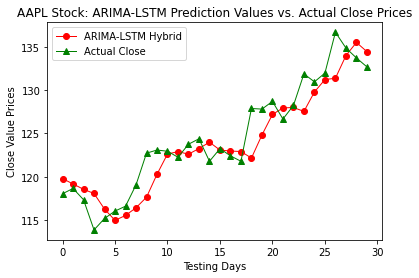

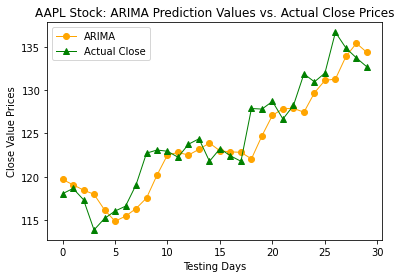

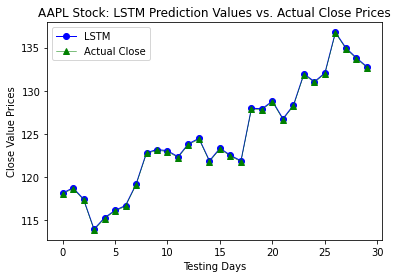

[0, 1, 2, 4, 10, 11, 14, 15, 16, 17, 21, 22, 25, 27, 28, 29]
[5, 6, 12, 13, 20, 24]
[3, 7, 8, 9, 18, 19, 23, 26]


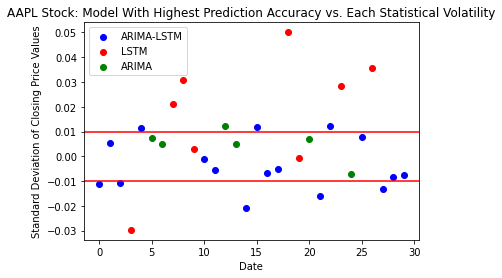

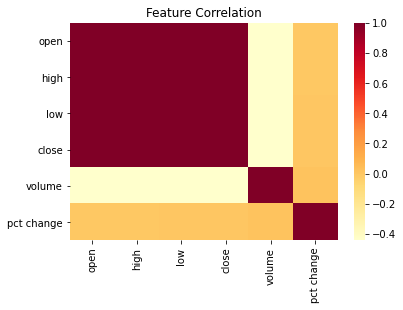


Correlation Between Features
                open      high       low     close    volume  pct change
open        1.000000  0.999906  0.999867  0.999784 -0.438456    0.000530
high        0.999906  1.000000  0.999826  0.999883 -0.436820    0.003491
low         0.999867  0.999826  1.000000  0.999890 -0.440984    0.004433
close       0.999784  0.999883  0.999890  1.000000 -0.438901    0.008501
volume     -0.438456 -0.436820 -0.440984 -0.438901  1.000000    0.023453
pct change  0.000530  0.003491  0.004433  0.008501  0.023453    1.000000


In [ ]:
for ma in simulation.keys():
    print('\n' + ma)
    print(simulation[ma]['accuracy'])
    print("Simple Moving Average")
    print('Prediction vs Close:\t\t' + str(round(100*simulation[ma]['accuracy']['prediction vs close'], 2))
          + '% Accuracy')
    print('Prediction vs Prediction:\t' + str(round(100*simulation[ma]['accuracy']['prediction vs prediction'], 2))
           + '% Accuracy')
    print('MSE:\t', simulation[ma]['final']['mse'],
          '\nRMSE:\t', simulation[ma]['final']['rmse'],
          '\nMAPE:\t', simulation[ma]['final']['mape'])
    
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
import matplotlib.pyplot as plt4
import matplotlib.pyplot as plt5
import matplotlib.pyplot as plt6

plt.plot(simulation[ma]['final']['prediction'][222:252], marker = "o", color='red', label='ARIMA-LSTM Hybrid', linewidth = 1)
plt.plot(actual[222:252], color='green', label='Actual Close', marker = "^", linewidth = 1)
plt.legend(loc='best')
plt.ylabel("Close Value Prices")
plt.xlabel("Testing Days")
plt.title(stock_name + " Stock: ARIMA-LSTM Prediction Values vs. Actual Close Prices")
plt.show()

plt4.plot(simulation[ma]['low_vol']['prediction'][222:252], marker = "o", color='orange', label='ARIMA', linewidth = 1)
plt4.plot(actual[222:252], color='green', label='Actual Close', marker = "^", linewidth = 1)
plt4.legend(loc='best')
plt4.ylabel("Close Value Prices")
plt4.xlabel("Testing Days")
plt4.title(stock_name + " Stock: ARIMA Prediction Values vs. Actual Close Prices")
plt4.show()

plt5.plot(simulation[ma]['high_vol']['prediction'][222:252] + actual[222:252] + 1.5, marker = "o", color='blue', label='LSTM', linewidth = 1)
plt5.plot(actual[222:252], color='green', label='Actual Close', marker = "^", linewidth = .5)
plt5.legend(loc='best')
plt5.ylabel("Close Value Prices")
plt5.xlabel("Testing Days")
plt5.title(stock_name + " Stock: LSTM Prediction Values vs. Actual Close Prices")
plt5.show()

import math
arima_lstm_scatter = []
arima_lstm_scatter_y = []

lstm_scatter = []
lstm_scatter_y = []

arima_scatter = []
arima_scatter_y = []

for i in range(0,30):
  value = abs(simulation[ma]['final']['prediction'][222+i] - actual[222+i])
  if (value > abs(simulation[ma]['high_vol']['prediction'][222+i]) + 2.2):
    lstm_scatter.append(i)
  elif value > abs(simulation[ma]['low_vol']['prediction'][222+i] - actual[222+i] + 1.9):
    arima_scatter.append(i)
  else:
    arima_lstm_scatter.append(i)
print(arima_lstm_scatter)
print(arima_scatter)
print(lstm_scatter)
for i in arima_lstm_scatter:
  arima_lstm_scatter_y.append(data['pct change'][-30+i])
for i in lstm_scatter:
  lstm_scatter_y.append(data['pct change'][-30+i])
for i in arima_scatter:
  arima_scatter_y.append(data['pct change'][-30+i])
plt3.scatter(arima_lstm_scatter, arima_lstm_scatter_y, marker = "o", color = "blue", label = "ARIMA-LSTM")
plt3.scatter(lstm_scatter, lstm_scatter_y, marker = "o", color = "red", label = "LSTM")
plt3.scatter(arima_scatter, arima_scatter_y, marker = "o", color = "green", label = "ARIMA")
plt.axhline(y=-0.01, color='r', linestyle='-')
plt.axhline(y=0.01, color='r', linestyle='-')
plt3.legend(loc='best')
plt3.ylabel("Standard Deviation of Closing Price Values")
plt3.xlabel("Date")
plt3.title(stock_name + " Stock: Model With Highest Prediction Accuracy vs. Each Statistical Volatility")
plt3.show()

#print("ARIMA-LSTM: Overall - %" + (arima_lstm_scatter.count / 30 * 100))
#print("ARIMA-LSTM: Overall - %" + (lstm_scatter.count / 30 * 100) + " No volatility - %" + (3 / 15 * 100) + " Fall Volaltility - %" + (4 / 6 * 100) + " Rise Volaitlity - %" + (4 / 9 * 100))

import seaborn as sns
corr = data.corr()
ax = sns.heatmap(corr, cmap="YlOrRd")
ax.set_title("Feature Correlation")
plt.show()
print("\nCorrelation Between Features")
print(corr)